In [4]:
import numpy as np
from PIL import Image
from PIL import ImageDraw
import os, sys
import scipy.ndimage
import pickle
from multiprocessing import Pool
from skimage import measure, morphology
import random
import pylab
import skimage.transform
from skimage.feature import canny
from skimage.filters import sobel
from copy import copy
import pydicom as pdcm
import time

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import imshow, figure, hist, plot, scatter, colorbar
get_ipython().magic('matplotlib inline')

In [5]:
def flipImage(img):
    leftCount = []
    rightCount = []
    for row in range(img.shape[0]):
        leftCount.append(img[row][0:int(img.shape[1]/2)])
        rightCount.append(img[row][int(img.shape[1]/2):img.shape[1]-1])
    left = np.mean(leftCount)
    right = np.mean(rightCount)
    if right > left:
        img = np.fliplr(img)
    
    return img

In [6]:
def vertBarRemoval(ogimg):
    img = copy(ogimg)
    newIm = np.rot90(img,3)
    row = 0
    while row < newIm.shape[0]:
        if np.mean(newIm[row]) >= 240 or (np.mean(newIm[row]) < 5 and row < img.shape[0]/4):
            newIm = newIm[row+1:newIm.shape[0]]
        else:
            row += 1
    newIm = newIm[2:][:]    
    newIm = skimage.transform.resize(np.rot90(newIm), (224,224))
    return newIm

In [7]:
def smooth(x,window_len=11,window='hanning'):
    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y

In [9]:
def horizBarRemoval(ogimg):
    newIm = copy(ogimg)
    row = 0
    while row < newIm.shape[0]:
        rowMean = np.mean(newIm[row])
        rowHalfStd = np.std(newIm[row][0:round(newIm.shape[1]/2)])
        rowHalfMean = np.mean(newIm[row][0:round(newIm.shape[1]/2)])
        rowEdgeDiff = abs(np.mean(newIm[row][0:10]) - np.mean(newIm[row][-11:-1]))
        if rowMean > 80 and rowEdgeDiff < 100 and (row < 25 or row > newIm.shape[0] - 25):
            if row < newIm.shape[0]/2:
                newIm = newIm[row+1:newIm.shape[0]]
            else:
                newIm[row] = np.zeros(newIm.shape[1])
                row += 1
        elif rowMean > 100 and rowHalfStd < 10 and (row < 25 or row > newIm.shape[0] - 25):
            if row < newIm.shape[0]/2:
                newIm = newIm[row+1:newIm.shape[0]]
            else:
                newIm[row] = np.zeros(newIm.shape[1])
                row += 1
        elif rowHalfMean > 200 and row < newIm.shape[0]/5:
            if row < newIm.shape[0]/2:
                newIm = newIm[row+1:newIm.shape[0]]
            else:
                newIm[row] = np.zeros(newIm.shape[1])
                row += 1
        else:
            row +=1
            
    newIm = newIm[5:newIm.shape[0]]   
    newIm = skimage.transform.resize(newIm, (224,224))
    newIm[-10:newIm.shape[0]] = 0
    
    return newIm

In [33]:
def backgroundRemoval(ogimg):
    img = copy(ogimg)
    
    hist, bins = np.histogram(im.ravel(),256,[0,256])
    midMax = max(hist[50:200])
    cutOff = -1
    for i in range(np.where(hist == midMax)[0][0]):
        if hist[i] > midMax:
            cutOff = i + 1
            
    for row in range(img.shape[0]):
        for col in range(img.shape[1]):
            if img[row][col] <= cutOff:
                img[row][col] = 0
    
    row = 0
    endPoints = []
    while row < img.shape[0]:
        for col in range(img.shape[1]):
            if img[row][col] == 0 and col > img.shape[1]/2:
                endPoints.append((col, row))
                break
                
        row += 1
        
    x_val = [x[0] for x in endPoints]
    y_val = [x[1] for x in endPoints]
    sx = smooth(np.asarray(x_val),11)
    sx = sx[round((len(sx)-len(x_val))/2):round((len(sx)-(len(sx)-len(x_val))/2))]
    
    for i, el in enumerate(y_val):
        for col in range(img.shape[1]):
            if col > sx[i]:
                img[el][col] = 0
        
    return img

In [140]:
def cannyCrop(img, canNum, tryCount=0):
    canIm = canny(img, canNum)
    newIm = copy(img) # Coppy to crop at end of function
    plt.imshow(canIm, cmap='gray')
    #plt.show()
    
    # Finds all instances of non-false pixels in the canny image
    lineList1 = []
    for row in range(canIm.shape[0]):
        tempList = []
        for col in range(canIm.shape[1]):
            if canIm[row][col] == True and col > 5:
                tempList.append(col)
        lineList1.append(tempList)
    
    # Finds all instances of pixels part of continuous line from previous lists
    newlineList = []
    i = 0
    while i < len(lineList1):
        tempList = []
        for num in lineList1[i]:
            if num in lineList1[i+1] or num-1 in lineList1[i+1]:
                tempList.append(num)
        newlineList.append(tempList)
        i += 1
        
    # Finds first non-empty row to find starting points for lines to select
    rowNum = 0
    for num, row in enumerate(newlineList):
        if row != [] and num > 2:
            starterRow = row
            break
            
        rowNum += 1
    
    # Populate dictionary with line starting point and line path
    lineDict = {}
    for el in starterRow:
        lineDict.update({el:[el]})
    
    # Fill line path if within max of 2 to the left and right of last pixel position
    # allowing 1 pixel gap down/up
    
    i = rowNum + 1
    while i < len(newlineList)-1:
        for lineList in list(lineDict.values()):
            if lineList[-1] != -1:
                if lineList[-1]-2 in lineList1[i]:
                    num = lineList[-1]-2
                    dep = i
                elif lineList[-1]-1 in lineList1[i]:
                    num = lineList[-1]-1
                    dep = i
                elif lineList[-1] in lineList1[i]:
                    num = lineList[-1]
                    dep = i
                elif lineList[-1]+1 in lineList1[i]:
                    num = lineList[-1]+1
                    dep = i
                elif lineList[-1]+2 in lineList1[i]:
                    num = lineList[-1]+2
                    dep = i
                    
                elif lineList[-1]-2 in lineList1[i+1]:
                    num = lineList[-1]-2
                    dep = i+1
                elif lineList[-1]-1 in lineList1[i+1]:
                    num = lineList[-1]-1
                    dep = i+1           
                elif lineList[-1] in lineList1[i+1]:
                    num = lineList[-1]
                    dep = i+1
                elif lineList[-1]+1 in lineList1[i+1]:
                    num = lineList[-1]+1
                    dep = i+1
                elif lineList[-1]+2 in lineList1[i+1]:
                    num = lineList[-1]+2
                    dep = i+1
                    
                elif lineList[-1]-2 in lineList1[i+2]:
                    num = lineList[-1]-2
                    dep = i+2         
                elif lineList[-1]-1 in lineList1[i+2]:
                    num = lineList[-1]-1
                    dep = i+2                  
                elif lineList[-1] in lineList1[i+2]:
                    num = lineList[-1]
                    dep = i+2         
                elif lineList[-1]+1 in lineList1[i+2]:
                    num = lineList[-1]+1
                    dep = i+2         
                elif lineList[-1]+2 in lineList1[i+2]:
                    num = lineList[-1]+2
                    dep = i+2         
                    
                else:
                    num = -1 # end of line condition
                
                while True:
                    if num-1 in lineList1[dep]:
                        num = num-1
                    else:
                        break
                        
                lineList.append(num)
                                    
        if 0 == len(lineDict):
            break # if all lines are finished, end looping
        i += 1
    
    #print(lineList1)
    #print(newlineList)
    #print(lineDict)
    # Find longest such line (what if i want line that isnt longest??) **
    maxVal = 0
    maxKey = 0
    for key in list(lineDict.keys()):
        case1 = len(lineDict[key]) > maxVal
        #case2 = int(key) < img.shape[1]/2
        case2 = len(lineDict[key]) < img.shape[0]*3/4
        #case3 = max(lineDict[key]) < img.shape[1]*3/4
        p11, p12 = lineDict[key][0],lineDict[key][-2]
        slope = (p11 - p12) / len(lineDict[key])
        #print(slope)
        case3 = slope > 0.2 or int(key) < img.shape[1]/4
        if case1 and case2 and case3:
            maxKey = key
            maxVal = len(lineDict[key])
    
    if tryCount > 5:
        newIm = img
    elif maxKey == 0 or len(lineDict[maxKey]) < img.shape[0]/10 :
        newIm = cannyCrop(newIm, canNum+1,tryCount+1)
        tryCount = tryCount + 1
    else:
        # Remove '-1' from end of list
        line = lineDict[maxKey][0:-2]
        
        if line == []:
            newIm = cannyCrop(newIm, canNum+1)
        else:

            # Make line same length as image
            for i in range(canIm.shape[0]):
                if i < rowNum:
                    line = [line[0]] + line
                elif i >= len(line):
                    line.append(-1)

            smline = smooth(np.asarray(line))
            smline = smline[round((len(smline)-len(line))/2):]
            line = smline[:img.shape[0]]

            # Removes all pixels from left of line
            for row in range(newIm.shape[0]):
                cutOff = line[row]
                for col in range(newIm.shape[1]):
                    if col < cutOff:
                        newIm[row][col] = -1
        
        
    return newIm

In [152]:
image_name = 'Mass-Training_P_00543_RIGHT_MLO'
image_path = 'D:/DDSM_Clean/Mass_Train/' + image_name

In [153]:
im = pdcm.dcmread(image_path)
im = im.pixel_array
im = skimage.transform.resize(im, (224,224))
im = flipImage(im*255)

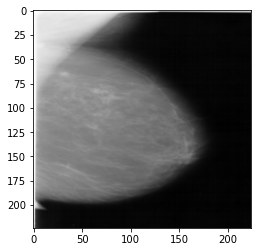

In [154]:
plt.imshow(im, cmap='gray')

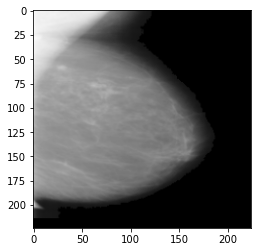

In [155]:
bgIm = vertBarRemoval(horizBarRemoval(backgroundRemoval(flipImage(im))))
plt.imshow(bgIm, cmap='gray')

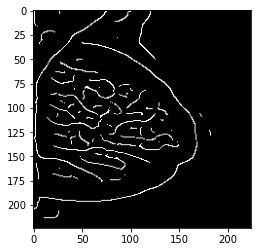

In [156]:
newIm = cannyCrop(bgIm, 4)

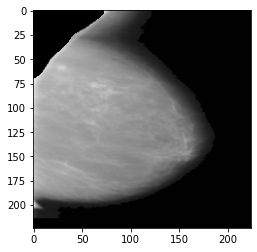

In [157]:
plt.imshow(newIm, cmap='gray')

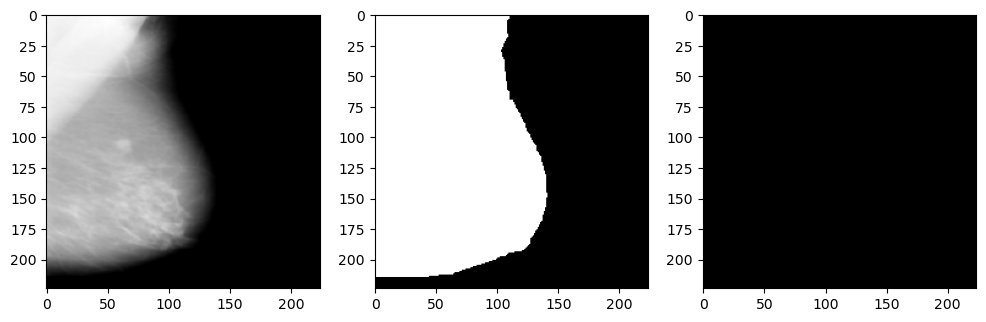

In [139]:
im1, im2, im3 = makeLabel(image_path)
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1,3,1)
plt.imshow(flipImage(im1), cmap='gray')
plt.subplot(1,3,2)
plt.imshow(im2, cmap='gray')
plt.subplot(1,3,3)
plt.imshow(im3, cmap='gray')
plt.show()

In [158]:
def makeLabel(im_path):
    im = pdcm.dcmread(im_path)
    im = im.pixel_array
    im = skimage.transform.resize(im, (224,224))
    im = im*255
    noCrop = vertBarRemoval(horizBarRemoval(backgroundRemoval(flipImage(im))))
    label3 = cannyCrop(vertBarRemoval(horizBarRemoval(backgroundRemoval(flipImage(im)))), 4)
    
    for row in range(label3.shape[0]):
        for col in range(label3.shape[1]):
            if label3[row][col] == -1:
                label3[row][col] = 1
            elif label3[row][col] > 0:
                label3[row][col] = 2
                
    label2 = copy(label3)
    
    for row in range(label2.shape[0]):
        for col in range(label2.shape[1]):
            if label2[row][col] == 2:
                label2[row][col] = 0
                
    return noCrop, label3, label2

In [159]:
def prepImages(from_path, to_path_im, to_path_label3, to_path_label2):
    for file in os.listdir(from_path):
        if file+'.png' not in os.listdir(to_path_label3) and 'CC' not in file:
            image_path = from_path + file
            img1, img2, img3 = makeLabel(image_path)

            mpimg.imsave(to_path_im+file+'.png', img1, cmap='gray')
            mpimg.imsave(to_path_label3+file+'.png', img2, cmap='gray')
            mpimg.imsave(to_path_label2+file+'.png', img3, cmap='gray')

In [126]:
for file in os.listdir('D:/DDSM_Clean/Calc_Train/'):
    if file+'.png' not in os.listdir('D:/DDSM_Segmentation/Train_Images/'):

Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes


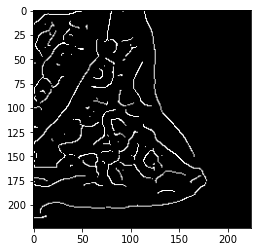

In [160]:
#prepImages('D:/DDSM_Clean/Calc_Test/','D:/DDSM_Segmentation/Test_Images/','D:/DDSM_Segmentation/Test_Labels_Full/','D:/DDSM_Segmentation/Test_Labels_Pec/')
#prepImages('D:/DDSM_Clean/Mass_Test/','D:/DDSM_Segmentation/Test_Images/','D:/DDSM_Segmentation/Test_Labels_Full/','D:/DDSM_Segmentation/Test_Labels_Pec/')
#prepImages('D:/DDSM_Clean/Calc_Train/','D:/DDSM_Segmentation/Train_Images/','D:/DDSM_Segmentation/Train_Labels_Full/','D:/DDSM_Segmentation/Train_Labels_Pec/')
prepImages('D:/DDSM_Clean/Mass_Train/','D:/DDSM_Segmentation/Train_Images/','D:/DDSM_Segmentation/Train_Labels_Full/','D:/DDSM_Segmentation/Train_Labels_Pec/')